<a href="https://colab.research.google.com/github/jesvin1/EPAT_TIMESERIES/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/datadriveninvestor/some-stylized-facts-about-financial-time-series-with-python-11148137fccf

In [0]:
import pandas as pd
import pandas_datareader as web

In [0]:
df=web.DataReader("TATAMOTORS.NS",start='2009-1-1',end='2018-12-31',data_source='yahoo')

In [0]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,36.092899,33.757900,34.430698,34.836300,18566132.0,25.930439
2009-01-05,36.607300,34.638500,36.607300,35.311199,13382038.0,26.283934
2009-01-06,37.389000,34.737400,35.608101,36.894299,18622647.0,27.462311
2009-01-07,37.398899,33.451199,37.398899,34.460400,8271221.0,25.650639
2009-01-09,35.618000,31.106300,35.618000,32.798199,11836653.0,24.413376


In [0]:
ts=df.iloc[:,5:6]

In [0]:
ts.head()

,Adj Close
Date,
2009-01-02,25.930439
2009-01-05,26.283934
2009-01-06,27.462311
2009-01-07,25.650639
2009-01-09,24.413376


In [0]:
import matplotlib.pyplot as plt


(array([733408., 733773., 734138., 734503., 734869., 735234., 735599.,
        735964., 736330., 736695., 737060.]),
 <a list of 11 Text xticklabel objects>)

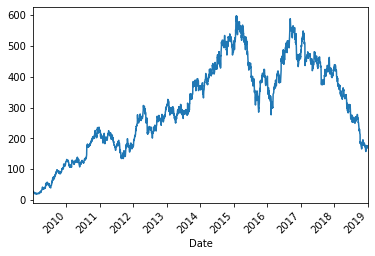

In [0]:
df.plot()
plt.xticks(rotation=45)

In [0]:
ts['daily_return']=ts['Adj Close'].pct_change(1)

/home/jesvinsebastian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


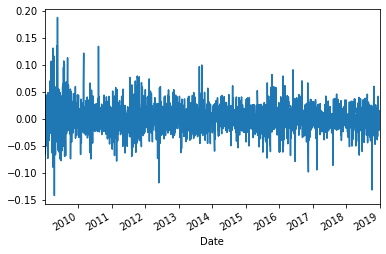

In [0]:
ts['daily_return'].plot()

In [0]:
import numpy as np

In [0]:
ts['log_return']=np.log(1+ts['daily_return'])

/home/jesvinsebastian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


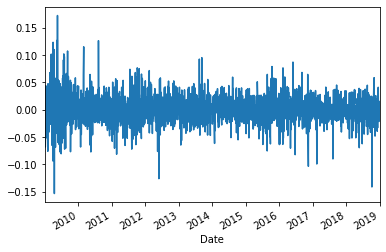

In [0]:
ts['log_return'].plot()

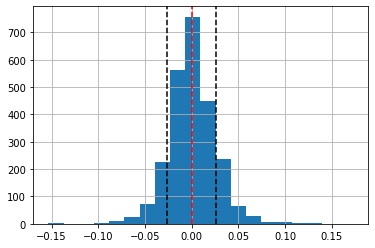

In [0]:
mean=ts['log_return'].mean()
std=ts['log_return'].std()
ts['log_return'].hist(bins=20)

plt.axvline(x=mean,color='r', linestyle='--')
plt.axvline(x=std, color='k', linestyle='--')
plt.axvline(x=-std, color='k', linestyle='--')

plt.show()


In [0]:
from scipy import stats

In [0]:
x=np.asarray(ts['log_return'].dropna())
stats.jarque_bera(x)
#Since the p-value is less than any significant level of aplha, 
#we can reject the Null and conclude that data do not follow a normal distribution.

(1297.7536040583857, 0.0)

In [0]:
stats.kurtosis(x)
#Is greater than 3. Hence, the return distribution is called “leptokurtic”.

3.534754356097589

In [0]:
!pip install yfinance